# Mini-Project - Exploratory Data Analysis Application with Python and SQL

<font color='yellow'>Project description:</font> exploratory analysis of a movie database with IMDB rating. The data is real and publicly available.

<font color='yellow'>Directory for the database:</font> https://www.imdb.com/interfaces/

<font color='yellow'>Languages used for this project:</font> Python and SQL

<font color='yellow'>Issues evaluated in this project:</font>

- 1 - What are the most common movie categories on IMDB?
- 2 - What is the number of titles by genre?
- 3 - What is the median rating of movies by genre?
- 4 - What is the median evaluation of movies regarding the year of premiere?
- 5 - What is the number of films evaluated by genre in relation to the year of release?
- 6 - What is the longest running movie?
- 7 - What is the relationship between duration and genre?
- 8 - What is the number of films produced per country?
- 9 - What are the top 10 best movies?
- 10 - What are the top 10 worst movies?

In [1]:
# Package for importing the IMDB database in SQLite
%pip install -q imdb-sqlite

# Package that allows obtaining information about countries from ISO code
%pip install -q pycountry

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Libraries used in the project
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style = 'whitegrid')

In [3]:
# Download the database
!imdb-sqlite
    # The library downloads the database from multiple zipped databases and unzips into a single imdb.db file

2022-02-24 17:33:13,666 DB already exists: (imdb.db). Refusing to modify. Exiting


# <font color='yellow'>Database Configuration</font>

In [4]:
# Create the connection to the database
conn = sqlite3.connect('imdb.db')

# Extracting the list of tables
tables = pd.read_sql_query('SELECT NAME AS "table_name" FROM sqlite_master WHERE type = "table"', conn)

print(tables)

  table_name
0     people
1     titles
2       akas
3       crew
4   episodes
5    ratings


In [5]:
# Convert the dataframe to a list
tables = tables['table_name'].values.tolist()

# Cycles through the list of database tables and extracts the schema of each
for table in tables: 
    query = 'PRAGMA TABLE_INFO({})'.format(table)
        # Pragma is an SQL extension specific to SQLite, used to modify or query an SQLite (https://www.sqlite.org/pragma.html)
    result = pd.read_sql_query(query, conn)
    print("Table Schema:", table)
    display(result)
    print('-'*100)

Table Schema: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------
Table Schema: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------
Table Schema: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------
Table Schema: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------
Table Schema: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------
Table Schema: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


# <font color='yellow'>Question 1 - What are the most common movie categories on IMDB?</font>

In [6]:
# Create the SQL query
commonCategories = 'SELECT type, COUNT(*) AS count FROM titles GROUP BY type'

# Extract the result of the previous query
resultCommonCategories = pd.read_sql_query(commonCategories, conn)

# View the result
display(resultCommonCategories)

,type,count
0,movie,602608
1,short,856897
2,tvEpisode,6518779
3,tvMiniSeries,42195
4,tvMovie,135036
5,tvPilot,2
6,tvSeries,221441
7,tvShort,10457
8,tvSpecial,36012
9,video,257613


In [7]:
# Add the percentage
resultCommonCategories['percentage'] = (resultCommonCategories['count']/resultCommonCategories['count'].sum())*100

display(resultCommonCategories)

,type,count,percentage
0,movie,602608,6.917370
1,short,856897,9.836367
2,tvEpisode,6518779,74.829418
3,tvMiniSeries,42195,0.484359
4,tvMovie,135036,1.550086
5,tvPilot,2,0.000023
6,tvSeries,221441,2.541933
7,tvShort,10457,0.120036
8,tvSpecial,36012,0.413384
9,video,257613,2.957154


In [8]:
# Create an "others" category to show only the 3 most relevant categories
others = {}
others['count'] = resultCommonCategories[resultCommonCategories['percentage']<5]['count'].sum()
others['percentage'] = resultCommonCategories[resultCommonCategories['percentage']<5]['percentage'].sum()
others['type'] = 'others'
resultCommonCategoriesNew = resultCommonCategories[resultCommonCategories['percentage']>5]
resultCommonCategoriesNew = resultCommonCategoriesNew.append(others, ignore_index=True)
resultCommonCategoriesNew = resultCommonCategoriesNew.sort_values(by='count', ascending=False)
resultCommonCategoriesNew

,type,count,percentage
2,tvEpisode,6518779,74.829418
1,short,856897,9.836367
3,others,733235,8.416844
0,movie,602608,6.917370


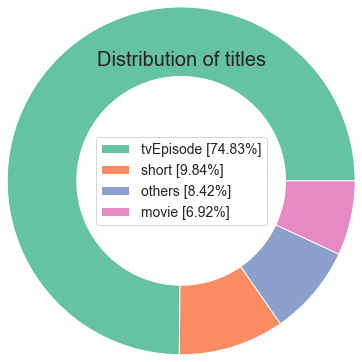

In [9]:
# Plot
cs = cm.Set2(np.arange(100))
figureCommonCategories = plt.figure()
plt.pie(resultCommonCategoriesNew['count'], labeldistance = 1, radius = 2, colors = cs, wedgeprops = dict(width = 0.8))
labels = [str(resultCommonCategoriesNew['type'][i])+' '+'['+str(round(resultCommonCategoriesNew['percentage'][i],2))+'%'+']' \
    for i in resultCommonCategoriesNew.index] # Synthesized label creation
plt.legend(labels = labels, loc = 'center', prop = {'size':14})
plt.title('Distribution of titles', loc = 'center', fontdict = {'fontsize':20, 'fontweight':20})
plt.show()

# <font color='yellow'>Question 2 - How many titles per genre?</font>

In [10]:
# Create the SQL query
titlesPerGenre = "SELECT genres, COUNT(*) AS count FROM titles WHERE type = 'movie' GROUP BY genres"

# Extract the result of the previous query
resultTitlesPerGenre = pd.read_sql_query(titlesPerGenre, conn)

# View the result
display(resultTitlesPerGenre)

,genres,count
0,Action,13822
1,"Action,Adult",11
2,"Action,Adult,Adventure",2
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1446,"Thriller,Western",42
1447,War,1287
1448,"War,Western",14
1449,Western,5101


In [11]:
# Convert strings to lowercase
resultTitlesPerGenre['genres'] = resultTitlesPerGenre['genres'].str.lower().values

# Remove missing values (NA)
tempResultTitlesPerGenre = resultTitlesPerGenre['genres'].dropna()

In [12]:
# Convert the genre column to a one-hot encoded array
array = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(tempResultTitlesPerGenre)
uniqueGenres = pd.DataFrame(array.transform(tempResultTitlesPerGenre).todense(), columns = array.get_feature_names(), index = tempResultTitlesPerGenre.index)
uniqueGenres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 0 to 1450
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1451 non-null   int64
 1   adult        1451 non-null   int64
 2   adventure    1451 non-null   int64
 3   animation    1451 non-null   int64
 4   biography    1451 non-null   int64
 5   comedy       1451 non-null   int64
 6   crime        1451 non-null   int64
 7   documentary  1451 non-null   int64
 8   drama        1451 non-null   int64
 9   family       1451 non-null   int64
 10  fantasy      1451 non-null   int64
 11  film-noir    1451 non-null   int64
 12  game-show    1451 non-null   int64
 13  history      1451 non-null   int64
 14  horror       1451 non-null   int64
 15  music        1451 non-null   int64
 16  musical      1451 non-null   int64
 17  mystery      1451 non-null   int64
 18  n            1451 non-null   int64
 19  news         1451 non-null   int64
 20  reality-

In [13]:
# Remove values equal to n
uniqueGenres = uniqueGenres.drop(columns = 'n', axis = 0)

# Calculate the percentage
uniqueGenresPercentage = 100 * pd.Series(uniqueGenres.sum().sort_values(ascending = False)/uniqueGenres.shape[0])

# Creating a dataframe to compose the data
genreCounts = []
percentageCounts = []
dfTitlesPerGenre = pd.DataFrame()
for i in range(int(uniqueGenresPercentage.count())):
    genreCounts.append(uniqueGenresPercentage.index[i])
    percentageCounts.append(uniqueGenresPercentage.values[i])
dfTitlesPerGenre['genre'] = genreCounts
dfTitlesPerGenre['percentage'] = percentageCounts
display(dfTitlesPerGenre)

,genre,percentage
0,drama,18.194349
1,comedy,16.815989
2,documentary,15.851137
3,adventure,14.817367
4,action,14.403859
5,romance,13.370090
6,crime,13.094418
7,mystery,12.474156
8,thriller,12.336320
9,fantasy,12.198484


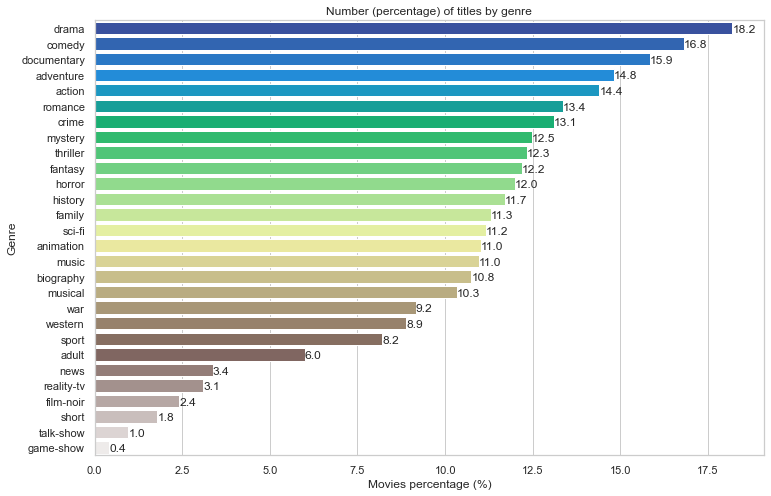

In [14]:
# Plot
figureTitlesPerGenre = plt.figure(figsize = (12,8))
sns.barplot(y = dfTitlesPerGenre.genre, x = dfTitlesPerGenre.percentage, orient = 'h', palette = 'terrain')
for i in range(len(dfTitlesPerGenre.index)):
    plt.text(dfTitlesPerGenre['percentage'][dfTitlesPerGenre.index[i]], i + 0.25, round(dfTitlesPerGenre['percentage'][dfTitlesPerGenre.index[i]],1))
plt.ylabel('Genre')
plt.xlabel('Movies percentage (%)')
plt.title('Number (percentage) of titles by genre')
plt.show()

# <font color='yellow'>Question 3 - What is the median rating of movies by genre?</font>

In [15]:
# Create the SQL query
medianRating = "SELECT rating, genres FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE premiered <= 2023 AND type = 'movie'"

# Extract the result of the previous query
medianRating = pd.read_sql_query(medianRating, conn)

# View the result
display(medianRating)

,rating,genres
0,4.5,\N
1,6.1,"Action,Adventure,Biography"
2,5.2,Drama
3,4.5,Drama
4,3.8,Drama
...,...,...
275092,5.8,Thriller
275093,6.4,"Drama,History"
275094,3.8,"Adventure,History,War"
275095,8.3,Drama


In [16]:
# Creation of a function to automate the return of genres (repeated throughout the project)
def returnGenre(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    array = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    uniqueGenres = array.get_feature_names()
    uniqueGenres = [genre for genre in uniqueGenres if len(genre) > 1]
    return uniqueGenres

# Use of created function
uniqueGenres = returnGenre(medianRating)
uniqueGenres

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [17]:
genreCounts = []
genreRatings = []

# Loop used to create lists for the dataframe of the graphical view
for item in uniqueGenres:
    
    # Returns the movie count by genre
    query = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    result = pd.read_sql_query(query, conn)
    genreCounts.append(result.values[0][0])

    # Returns the median rating of movies by genre
    query = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    result = pd.read_sql_query(query, conn)
    genreRatings.append(np.median(result['rating']))

In [18]:
# Creating a final dataframe to compose the data
dfMedianRatings = pd.DataFrame()
dfMedianRatings['genres'] = uniqueGenres
dfMedianRatings['count'] = genreCounts
dfMedianRatings['rating'] = genreRatings
dfMedianRatings = dfMedianRatings.sort_values(by = 'rating', ascending = False)
display(dfMedianRatings)

,genres,count,rating
12,game-show,3,8.90
7,documentary,40828,7.30
18,news,652,7.30
22,short,22,7.15
4,biography,8303,7.00
24,talk-show,9,7.00
13,history,7584,6.90
23,sport,3253,6.70
11,film-noir,764,6.60
15,music,12506,6.60


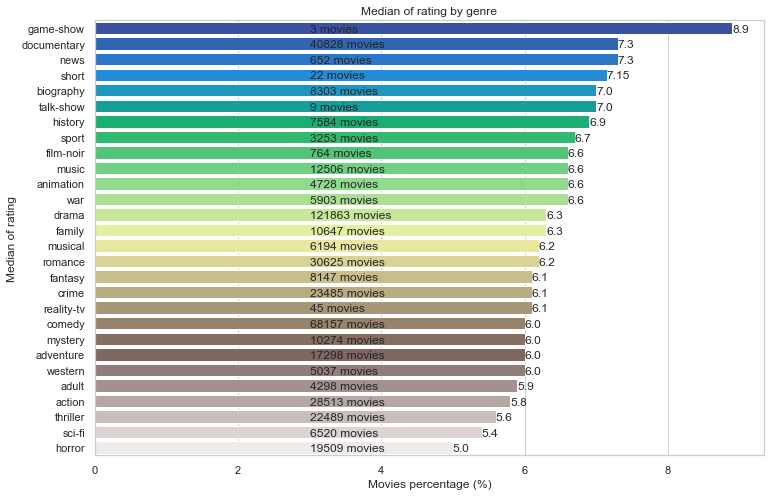

In [19]:
# Plot
figureMedianRatings = plt.figure(figsize = (12,8))
sns.barplot(y = dfMedianRatings.genres, x = dfMedianRatings.rating, orient = 'h', palette = 'terrain')
for i in range(len(dfMedianRatings.index)):
    plt.text(3.0, i + 0.25, str(dfMedianRatings['count'][dfMedianRatings.index[i]]) + ' movies')
    plt.text(dfMedianRatings['rating'][dfMedianRatings.index[i]], i + 0.25, round(dfMedianRatings['rating'][dfMedianRatings.index[i]],2))
plt.ylabel('Median of rating')
plt.xlabel('Movies percentage (%)')
plt.title('Median of rating by genre')
plt.show()

# <font color='yellow'>Question 4 - What is the median rating of films in relation to the year they were released?</font>

In [20]:
# Create the SQL query
medianRatingPerYear = "SELECT primary_title, rating, premiered FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE premiered <= 2023 AND type = 'movie' ORDER BY premiered"

# Extract the result of the previous query
medianRatingPerYear = pd.read_sql_query(medianRatingPerYear, conn)

# View the result
display(medianRatingPerYear)

,primary_title,rating,premiered
0,Birmingham,6.2,1896
1,Reproduction of the Corbett and Fitzsimmons Fight,4.5,1897
2,Jeffries-Sharkey Contest,4.0,1899
3,Sharkey-McCoy Fight Reproduced in 10 Rounds,3.7,1899
4,The Republican National Convention,6.0,1900
...,...,...,...
275092,The Photo Camera,7.0,2022
275093,Nightshade,3.7,2022
275094,Theal,4.1,2022
275095,Hotel Transylvania 4: Transformania,6.1,2022


In [21]:
# Calculation of the median over time (separated by years)
medianRatings = []
for year in set(medianRatingPerYear['premiered']):
    medianRatings.append(np.median(medianRatingPerYear[medianRatingPerYear['premiered'] == year]['rating']))

# Creating a dataframe to compose the data
dfMedianRatings = pd.DataFrame()
dfMedianRatings['medianRating'] = medianRatings
dfMedianRatings['year'] = list(set(medianRatingPerYear['premiered']))
dfMedianRatings = dfMedianRatings.sort_values(by = 'year', ascending = True)
display(dfMedianRatings)

,medianRating,year
0,6.20,1896
1,4.50,1897
2,3.85,1899
3,5.85,1900
4,4.60,1901
...,...,...
121,6.30,2018
122,6.30,2019
123,6.30,2020
124,6.60,2021


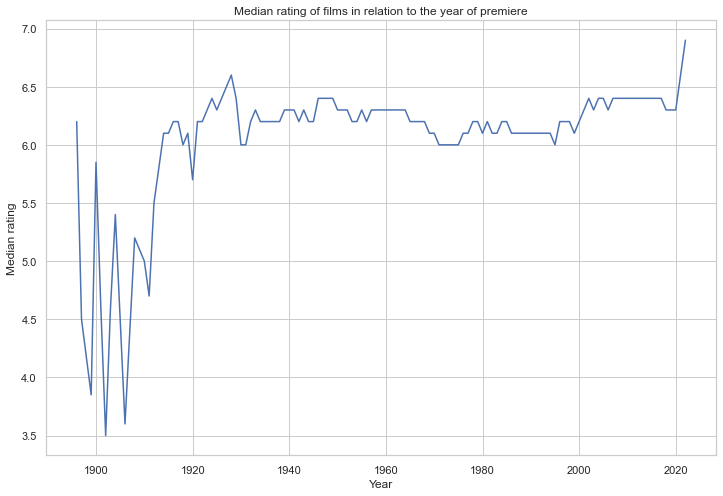

In [22]:
# Plot
plt.figure(figsize = (12,8))
plt.plot(dfMedianRatings['year'], dfMedianRatings['medianRating'])
plt.xlabel('Year')
plt.ylabel('Median rating')
plt.title('Median rating of films in relation to the year of premiere')
plt.show()

# <font color='yellow'>Question 5 - What is the number of movies evaluated by genre in relation to the year of premiere?</font>

In [23]:
# Create the SQL query
premiereYear = "SELECT genres, premiered FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE premiered <= 2022 AND type = 'movie' ORDER BY premiered"

# Extract the result of the previous query
premiereYear = pd.read_sql_query(premiereYear, conn)

# View the result
display(premiereYear)

,genres,premiered
0,Documentary,1896
1,"Documentary,News,Sport",1897
2,"Documentary,News,Sport",1899
3,"Documentary,News,Sport",1899
4,Documentary,1900
...,...,...
275092,Drama,2022
275093,"Mystery,Thriller",2022
275094,Action,2022
275095,"Adventure,Animation,Comedy",2022


In [24]:
# Separates genres into single genres
uniqueGenres = returnGenre(premiereYear)
display(uniqueGenres)

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [25]:
genreCounts = []

# Returns the movie count by genre
for item in uniqueGenres:
        
    query = 'SELECT COUNT(genres) AS count FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND premiered <= 2022'
    result = pd.read_sql_query(query, conn)
    genreCounts.append(result['count'].values[0])

print(genreCounts)

[28510, 4298, 17296, 4726, 8302, 68146, 23484, 40823, 121853, 10645, 8147, 764, 3, 7584, 19505, 12506, 6194, 10274, 652, 45, 30623, 6520, 22, 3253, 9, 22489, 5903, 5037]


In [26]:
# Prepare a final dataframe and determine the main genres (top 6)
dfPremiereYear = pd.DataFrame()
dfPremiereYear['genres'] = uniqueGenres
dfPremiereYear['count'] = genreCounts
dfPremiereYear = dfPremiereYear.sort_values(by = 'count', ascending = False)
dfTopGenres = dfPremiereYear.head(6)
display(dfTopGenres)

,genres,count
8,drama,121853
5,comedy,68146
7,documentary,40823
20,romance,30623
0,action,28510
6,crime,23484


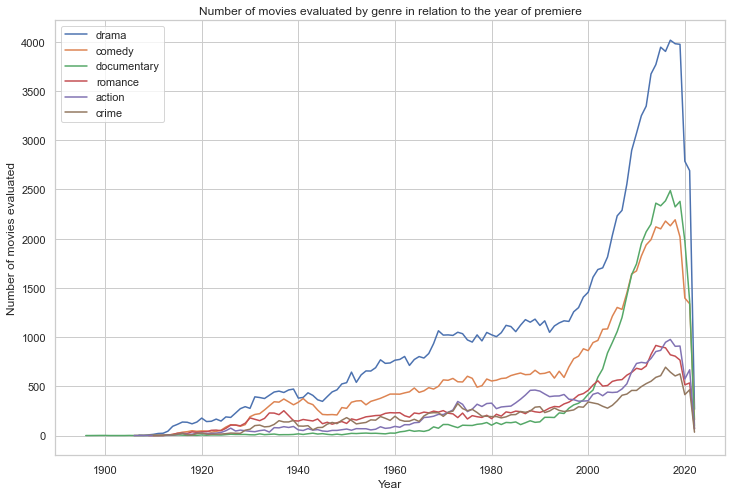

In [27]:
# Plot
plt.figure(figsize = (12,8))
for item in dfTopGenres['genres']: # Loop to count the number of movies per year by genre
    query = 'SELECT COUNT(*) AS numberOfMovies, premiered AS year FROM titles JOIN ratings ON titles.title_id = ratings.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND year <=2022 GROUP BY year'
    result = pd.read_sql_query(query, conn)
    plt.plot(result['year'], result['numberOfMovies'])
plt.xlabel('Year')
plt.ylabel('Number of movies evaluated')
plt.title('Number of movies evaluated by genre in relation to the year of premiere')
plt.legend(labels = dfTopGenres['genres'])
plt.show()

# <font color='yellow'>Question 6 - Which movie has the longest running time (with percentiles)?</font>

In [28]:
# Create the SQL query
longestRunningTime = "SELECT original_title AS title, runtime_minutes AS runningTime FROM titles WHERE premiered <= 2022 AND type = 'movie' AND runningTime != 'NaN' ORDER BY runningTime DESC"

# Extract the result of the previous query
longestRunningTime = pd.read_sql_query(longestRunningTime, conn)

# View the result
display(longestRunningTime)

,title,runningTime
0,Logistics,51420
1,Ambiancé,43200
2,Carnets Filmés (Liste Complète),28643
3,Modern Times Forever,14400
4,Qw,10062
...,...,...
373243,Suck and Smile,1
373244,Kisses,1
373245,Lip Touch,1
373246,Aysu,1


In [29]:
# Loop to determine each percentile
for i in range(101): # Range from 0 to 100
    percentile = round(np.percentile(longestRunningTime['runningTime'], i), 2)
    print('The', i, 'percent of duration is:', percentile)

The 0 percent of duration is: 1.0
The 1 percent of duration is: 45.0
The 2 percent of duration is: 48.0
The 3 percent of duration is: 50.0
The 4 percent of duration is: 50.0
The 5 percent of duration is: 52.0
The 6 percent of duration is: 52.0
The 7 percent of duration is: 53.0
The 8 percent of duration is: 55.0
The 9 percent of duration is: 56.0
The 10 percent of duration is: 58.0
The 11 percent of duration is: 59.0
The 12 percent of duration is: 60.0
The 13 percent of duration is: 60.0
The 14 percent of duration is: 60.0
The 15 percent of duration is: 61.0
The 16 percent of duration is: 63.0
The 17 percent of duration is: 65.0
The 18 percent of duration is: 66.0
The 19 percent of duration is: 68.0
The 20 percent of duration is: 69.0
The 21 percent of duration is: 70.0
The 22 percent of duration is: 70.0
The 23 percent of duration is: 72.0
The 24 percent of duration is: 73.0
The 25 percent of duration is: 74.0
The 26 percent of duration is: 75.0
The 27 percent of duration is: 75.0
The

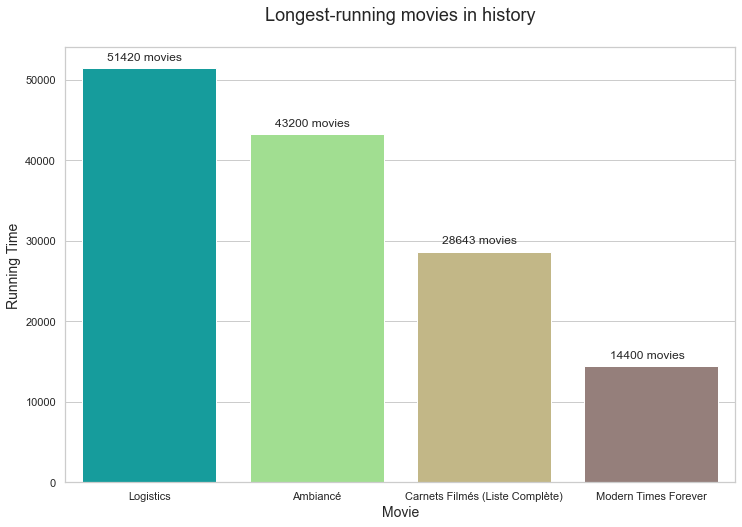

In [30]:
# Plot
figureLongestRunningTime = plt.figure(figsize = (12,8))
sns.barplot(x = longestRunningTime['title'][:4], y = longestRunningTime['runningTime'][:4], orient = 'v', palette = 'terrain')
for i in range(4):
    plt.text(i - 0.25, i + 1000 + longestRunningTime['runningTime'][i], str(longestRunningTime['runningTime'][i]) + ' movies')
plt.ylabel('Running Time', size = 14)
plt.xlabel('Movie', size = 14)
plt.title('Longest-running movies in history\n', size = 18)
plt.show()

# <font color='yellow'>Question 7 - What is the relationship between duration and genre?</font>

In [31]:
# Create the SQL query
durationAndGenre = "SELECT genres, runtime_minutes AS runningTime FROM titles WHERE premiered <= 2022 AND type = 'movie' AND runningTime != 'NaN' ORDER BY runningTime DESC"

# Extract the result of the previous query
durationAndGenre = pd.read_sql_query(durationAndGenre, conn)

# View the result
display(durationAndGenre)

,genres,runningTime
0,Documentary,51420
1,Documentary,43200
2,Documentary,28643
3,Documentary,14400
4,Drama,10062
...,...,...
373243,Romance,1
373244,Romance,1
373245,Romance,1
373246,Drama,1


In [32]:
# Return the unique genres of the filtered dataframe
uniqueGenres = returnGenre(durationAndGenre)
uniqueGenres

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [33]:
medianDurationByGenre = []

# Returns the median running time of movies by genre
for item in uniqueGenres:
    query = "SELECT genres, runtime_minutes AS runningTime FROM titles WHERE genres LIKE" + '\''+'%'+item+'%'+'\' AND type=\'movie\' AND runningTime!=\'NaN\''
    result = pd.read_sql_query(query, conn)
    medianDurationByGenre.append(np.median(result['runningTime'].values[0]))

print(medianDurationByGenre)

[70.0, 80.0, 70.0, 70.0, 70.0, 49.0, 48.0, 60.0, 90.0, 50.0, 120.0, 80.0, 46.0, 50.0, 85.0, 56.0, 81.0, 90.0, 104.0, 78.0, 68.0, 195.0, 10.0, 70.0, 55.0, 48.0, 51.0, 56.0]


In [34]:
# Creating a final dataframe to compose the data
dfDurationByGenre = pd.DataFrame()
dfDurationByGenre['genres'] = uniqueGenres
dfDurationByGenre['medianDuration'] = medianDurationByGenre
dfDurationByGenre = dfDurationByGenre.sort_values(by = 'medianDuration', ascending = False)
display(dfDurationByGenre)

,genres,medianDuration
21,sci-fi,195.0
10,fantasy,120.0
18,news,104.0
17,mystery,90.0
8,drama,90.0
14,horror,85.0
16,musical,81.0
11,film-noir,80.0
1,adult,80.0
19,reality-tv,78.0


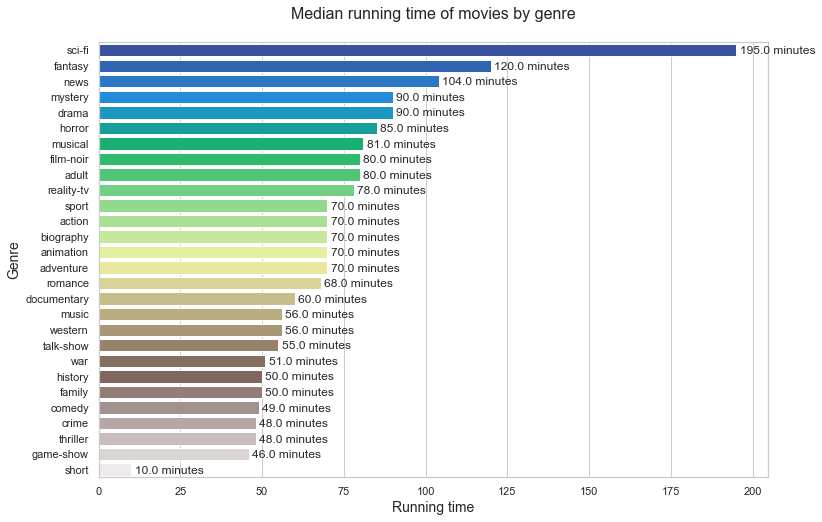

In [35]:
# Plot
figureMedianDurationByGenre = plt.figure(figsize = (12,8))
sns.barplot(y = dfDurationByGenre['genres'], x = dfDurationByGenre['medianDuration'], orient = 'h', palette = 'terrain')
for i in range(len(dfDurationByGenre.index)):
    plt.text(dfDurationByGenre['medianDuration'][dfDurationByGenre.index[i]] + 1, i + 0.25, str(round(dfDurationByGenre['medianDuration'][dfDurationByGenre.index[i]],2)) + ' minutes')
plt.ylabel('Genre', size = 14)
plt.xlabel('Running time', size = 14)
plt.title('Median running time of movies by genre\n', size = 16)
plt.show()

# <font color='yellow'>Question 8 - How many movies are produced per country?</font>

In [36]:
# Create the SQL query
moviesPerCountry = "SELECT region, COUNT(*) as count FROM akas JOIN titles ON akas.title_id = titles.title_id WHERE type = 'movie' GROUP BY region"

# Extract the result of the previous query
moviesPerCountry = pd.read_sql_query(moviesPerCountry, conn)

# View the result
display(moviesPerCountry)

,region,count
0,None,532235
1,AD,22
2,AE,5045
3,AF,110
4,AG,12
...,...,...
230,YUCS,153
231,ZA,3170
232,ZM,15
233,ZRCD,2


In [37]:
# Remove from the first line with the sum of films without country identification
moviesPerCountry = moviesPerCountry.drop(moviesPerCountry.index[[0]])
display(moviesPerCountry)

,region,count
1,AD,22
2,AE,5045
3,AF,110
4,AG,12
5,AL,1267
...,...,...
230,YUCS,153
231,ZA,3170
232,ZM,15
233,ZRCD,2


In [38]:
moviesPerCountryNew = pd.DataFrame()
lstRegions = []
lstCounts = []

# Creation of a new dataframe with the name of the countries converted from the code (ISO 3166), selecting the top 20
for i in range(1, len(moviesPerCountry)+1):
    try:
        var = pycountry.countries.get(alpha_2 = moviesPerCountry['region'][i])
        lstRegions.append(var.name)
        lstCounts.append(moviesPerCountry['count'][i])
    except:
        continue

moviesPerCountryNew['region'] = lstRegions
moviesPerCountryNew['count'] = lstCounts
moviesPerCountryNew = moviesPerCountryNew.sort_values(by = 'count', ascending = False)
dfMoviesPerCountry = moviesPerCountryNew.head(20)
display(dfMoviesPerCountry)

,region,count
199,United States,307194
65,United Kingdom,157967
96,Japan,90704
63,France,83893
89,India,79413
32,Canada,75944
47,Germany,69794
93,Italy,64921
58,Spain,64701
26,Brazil,64571


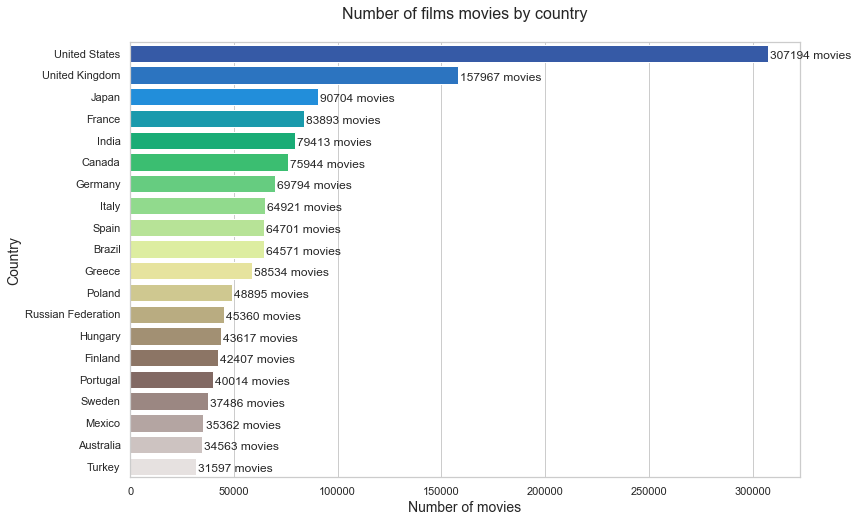

In [39]:
# Plot
figureMoviesPerCountry = plt.figure(figsize = (12,8))
sns.barplot(y = dfMoviesPerCountry['region'], x = dfMoviesPerCountry['count'], orient = 'h', palette = 'terrain')
for i in range(len(dfMoviesPerCountry)):
    plt.text(dfMoviesPerCountry['count'][dfMoviesPerCountry.index[i]] + 1000, i + 0.25, str(dfMoviesPerCountry['count'][dfMoviesPerCountry.index[i]]) + ' movies')
plt.ylabel('Country', size = 14)
plt.xlabel('Number of movies', size = 14)
plt.title('Number of films movies by country\n', size = 16)
plt.show()

# <font color='yellow'>Question 9 - What are the top 10 best movies?</font>

In [40]:
# Create the SQL query
top10BestMovies = "SELECT original_title, genres, rating FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE type = 'movie' AND premiered <=2022 AND ratings.votes >= 25000 ORDER BY rating DESC"

# Extract the result of the previous query
top10BestMovies = pd.read_sql_query(top10BestMovies, conn)

# View the result
display(top10BestMovies)

,original_title,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,Hababam Sinifi,"Comedy,Drama",9.3
2,Jai Bhim,"Crime,Drama,Mystery",9.3
3,The Godfather,"Crime,Drama",9.2
4,Soorarai Pottru,Drama,9.1
...,...,...,...
5688,Elk*rtuk,"Crime,Drama,History",1.5
5689,Reis,"Biography,Drama",1.4
5690,Smolensk,"Drama,Thriller",1.2
5691,Sadak 2,"Action,Drama",1.1


In [41]:
# Use the generated dataframe and display the first 10 rows (already generated in descending order)
display(top10BestMovies.head(10))

,original_title,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,Hababam Sinifi,"Comedy,Drama",9.3
2,Jai Bhim,"Crime,Drama,Mystery",9.3
3,The Godfather,"Crime,Drama",9.2
4,Soorarai Pottru,Drama,9.1
5,CM101MMXI Fundamentals,"Comedy,Documentary",9.1
6,Aynabaji,"Crime,Mystery,Thriller",9.1
7,12 Angry Men,"Crime,Drama",9.0
8,The Godfather: Part II,"Crime,Drama",9.0
9,The Dark Knight,"Action,Crime,Drama",9.0


# <font color='yellow'>Question 10 - What are the top 10 worst movies?</font>

In [42]:
# Display the last 10 rows of the previously generated dataframe
top10WorstMovies = top10BestMovies.tail(10)
display(top10WorstMovies)

,original_title,genres,rating
5683,Disaster Movie,"Comedy,Sci-Fi",1.9
5684,Race 3,"Action,Crime,Thriller",1.9
5685,Manos: The Hands of Fate,Horror,1.8
5686,Radhe,"Action,Crime,Thriller",1.8
5687,Justin Bieber: Never Say Never,"Documentary,Music",1.6
5688,Elk*rtuk,"Crime,Drama,History",1.5
5689,Reis,"Biography,Drama",1.4
5690,Smolensk,"Drama,Thriller",1.2
5691,Sadak 2,"Action,Drama",1.1
5692,Cumali Ceber: Allah Seni Alsin,Comedy,1.0
